In [2]:
%load_ext autoreload
%autoreload 2

import itertools
import numpy as np
import matplotlib.pyplot as plt

from multiprocessing import Pool
import time
from tqdm import tqdm
import networkx as nx

from graph_generation import GenerateGraph, perturb_nx_graph
from models import GCN
from train import Trainer, Dataset
from embedding import Embedding, NodeEmbedding
from experiments import (train_take_embedding, plot_dim1, plot_dimN, plot_correlation_error, get_metrics, 
                         init_GCN, init_model_dataset, train_take_embedding_alreadyinit)
from config_valid import Config, TrainingMode
from plot_model import plot_model
from utils import plot_wo_outliers, plot_grafo2

import torch
from torch_geometric import nn
from torch_geometric.loader import DataLoader
device = torch.device('cuda')

from scipy import stats


from plt_parameters import init_params
init_params()

#from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
#event_acc = EventAccumulator(path="./runs/lr-0.01_epochs45_bs150_neurons-1-8-2_15Sep_16-15-16")
#event_acc.Reload()
# Show all tags in the log file
#print(event_acc.Tags())
#w_times, step_nums, vals = zip(*event_acc.Scalars('Test Loss'))

In [2]:
config_file = "configurations/classification_cm.yml"
config_c = Config(config_file)

In [3]:
gg = GenerateGraph(config_c)
dataset = gg.initialize_dataset()

Generating dataset...
Dataset generated


In [104]:
model = init_GCN(config_c, verbose=True)

GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 8)
    (1): GCNConv(8, 8)
    (2): GCNConv(8, 1)
  )
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
    (2): LeakyReLU(negative_slope=0.03)
  )
  (lin): Linear(in_features=1, out_features=2, bias=True)
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)


In [4]:
model, trainer, plot = init_model_dataset(config_c, dataset, verbose=True)

Initialize model
GCN(
  (convs): ModuleList(
    (0): GCNConv(1, 8)
    (1): GCNConv(8, 8)
    (2): GCNConv(8, 1)
  )
  (leakys): ModuleList(
    (0): LeakyReLU(negative_slope=0.03)
    (1): LeakyReLU(negative_slope=0.03)
    (2): LeakyReLU(negative_slope=0.03)
  )
  (lin): Linear(in_features=1, out_features=2, bias=True)
  (mean_pool): MeanAggregation()
  (drop): Dropout(p=0.5, inplace=False)
)
Loading Dataset...


100%|███████████████████████████████████████████████████████████████████| 600/600 [00:32<00:00, 18.19it/s]


Tempo impiegato: 33.05795431137085
aten::new_zeros %index.19 : Long(100000, strides=[1], requires_grad=0, device=cuda:0) = aten::new_zeros(%710, %563, %564, %565, %566, %567) # /home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch_geometric/nn/aggr/base.py:56:0



/home/daniele/anaconda3/envs/pytorch-geom/lib/python3.8/site-packages/torch/jit/_trace.py:983: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
Tensor-likes are not close!

Mismatched elements: 2 / 2 (100.0%)
Greatest absolute difference: 0.0017579495906829834 at index (0, 1) (up to 1e-05 allowed)
Greatest relative difference: 0.0050699685223087815 at index (0, 1) (up to 1e-05 allowed)

  _check_trace(


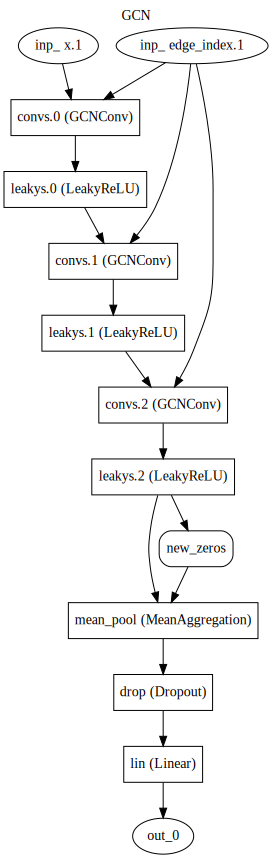

In [5]:
plot

In [34]:
ms = list(model.modules())

In [49]:
gcnconv = ms[1][0]
gpars = list(gcnconv.parameters())

In [55]:
gpars[0].data

tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [106]:
def view_parameters(model):
    for m in model.modules():
        if isinstance(m, nn.GCNConv):
            classname = m.__class__.__name__        
            print(f"classname: {classname} \n\t parameters: {list(m.parameters())} \n \n")
        #print(f"classname: {classname} \n\t parameters: {list(m.parameters())} \n\t bias: {m.bias} \n\t weights: {m.lin.weight} \n \n \n")

def new_parameters(model):
    new_par = []
    for m in model.modules():
        if isinstance(m, nn.GCNConv):
            shape = m.lin.weight.shape 
            custom_weight = torch.empty(shape)
            torch.nn.init.kaiming_normal_(custom_weight, mode='fan_out', nonlinearity='relu')
            new_par.append(custom_weight)
    return new_par
        
def modify_parameters(model, new_par):
    i = 0
    for m in model.modules():
        if isinstance(m, nn.GCNConv):
            shape = m.lin.weight.shape
            #custom_weight = torch.empty(shape)
            #4torch.nn.init.kaiming_normal_(custom_weight, mode='fan_out', nonlinearity='relu')
            m.lin.weight.data = torch.nn.parameter.Parameter(new_par[i])
            i += 1
            

In [107]:
print("Parametri attuali")
view_parameters(model)
print("Cambio i parametri...")
new_par = new_parameters(model)
print(new_par)
modify_parameters(model, new_par)
print("Parametri nuovi")
view_parameters(model)

Parametri attuali
classname: GCNConv 
	 parameters: [Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[ 0.3853],
        [-0.0560],
        [-0.2102],
        [-0.3396],
        [-0.5776],
        [-0.5019],
        [ 0.0789],
        [ 0.8130]], requires_grad=True)] 
 

classname: GCNConv 
	 parameters: [Parameter containing:
tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0', requires_grad=True), Parameter containing:
tensor([[-0.2981,  0.0649,  0.3622,  0.9682,  0.2155,  0.1719, -0.7820, -0.1540],
        [ 0.6822,  0.1566, -0.6111,  0.9864,  0.2897,  0.4252, -0.7813, -0.1397],
        [-1.1996, -0.7237, -0.0649, -0.8285, -0.4819, -0.3887,  0.9557,  1.0512],
        [-0.3821,  0.3007, -0.3396, -0.2508, -0.1191,  0.1102, -0.1369, -0.0737],
        [-0.3355,  0.6074,  0.2247, -0.3156, -0.0332, -0.3905, -0.4574, -0.0449],
        [-0.3267, -0.5723,  0.0574, -0.0240,  0.3622,  0.5599, -0.1955, -0.241

# Vari modi di fissare i pesi della rete:

In [8]:
conv1 = torch.nn.Conv2d(1,2,3)
torch.nn.init.xavier_uniform(conv1.weight)

/tmp/ipykernel_46641/3513158229.py:2: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(conv1.weight)


Parameter containing:
tensor([[[[ 0.2786, -0.3916,  0.2298],
          [-0.0658, -0.0619,  0.4706],
          [-0.0048,  0.0034,  0.3857]]],


        [[[ 0.1266, -0.2369,  0.3244],
          [ 0.3834, -0.3915, -0.2533],
          [ 0.1063,  0.4603, -0.3646]]]], requires_grad=True)

In [9]:
torch.nn.init.kaiming_uniform_(conv1.weight)
#init.kaiming_uniform_(self.weight, a=math.sqrt(5))

Parameter containing:
tensor([[[[-0.7651, -0.0394,  0.5059],
          [ 0.0521, -0.2367,  0.5064],
          [ 0.6224, -0.4585, -0.0053]]],


        [[[ 0.3680, -0.0266,  0.2351],
          [ 0.3666, -0.3639,  0.7486],
          [-0.1979,  0.0380, -0.6580]]]], requires_grad=True)

In [ ]:
fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
init.uniform_(self.bias, -bound, bound)

In [10]:
conv1.weight.data.fill_(0.01)

tensor([[[[0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100]]],


        [[[0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100],
          [0.0100, 0.0100, 0.0100]]]])

In [11]:
conv1.bias.data.fill_(0.01)

tensor([0.0100, 0.0100])

In [2]:
from enum import Enum
class Inits(Enum):
    normal = 'normal'
    constant = 'constant'
    uniform = 'uniform'
    eye = 'eye'
    dirac = 'dirac'
    xavier_uniform = 'xavier_uniform'

In [6]:
Inits.normal == 'normal'

False

### Init pytorch

In [ ]:
# https://pytorch.org/docs/stable/nn.init.html

torch.nn.init.normal_(tensor, mean=0, std=1)
torch.nn.init.constant_(tensor, value)
torch.nn.init.uniform_(tensor, a=0, b=1) # a: lower_bound, b: upper_bound
torch.nn.init.eye_(tensor)
torch.nn.init.dirac_(tensor) # tensor sdeve essere almeno 3D
torch.nn.init.xavier_uniform_(tensor, gain=1.0)  #values sampled from \mathcal{U}(-a, a)U(−a,a)
torch.nn.init.xavier_normal_(tensor, gain=1.0)  # values sampled from \mathcal{N}(0, \text{std}^2)N(0,std2)
torch.nn.init.kaiming_uniform_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
torch.nn.init.kaiming_normal_(tensor, a=0, mode='fan_in', nonlinearity='leaky_relu')
torch.nn.init.trunc_normal_(tensor, mean=0.0, std=1.0, a=- 2.0, b=2.0)
torch.nn.init.orthogonal_(tensor, gain=1)
torch.nn.init.sparse_(tensor, sparsity, std=0.01)
gain = torch.nn.init.calculate_gain(nonlinearity, param=None) # nonlinearity – the non-linear function (nn.functional name)

In [29]:
vect = torch.empty((100,100))
vect2 = torch.empty((100,100))

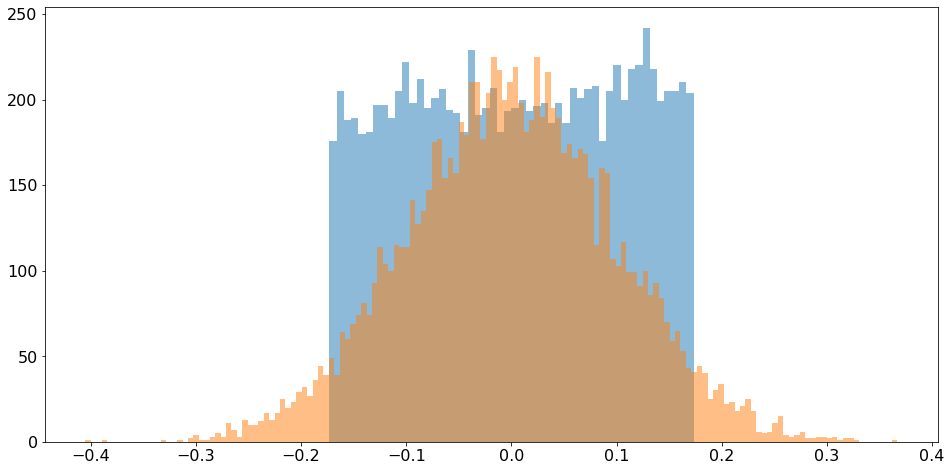

In [37]:
torch.nn.init.xavier_uniform_(vect, gain=1.0)
plt.hist(vect.flatten().numpy(), bins=50, alpha=0.5);
torch.nn.init.xavier_normal_(vect, gain=1.0)
plt.hist(vect.flatten().numpy(), bins=150, alpha=0.5);

### Init pytorch geom

In [15]:
from torch_geometric.nn import inits

#### Questa è l'inizializzazione di default di un Linear, che sta anche dentro il layer GCN

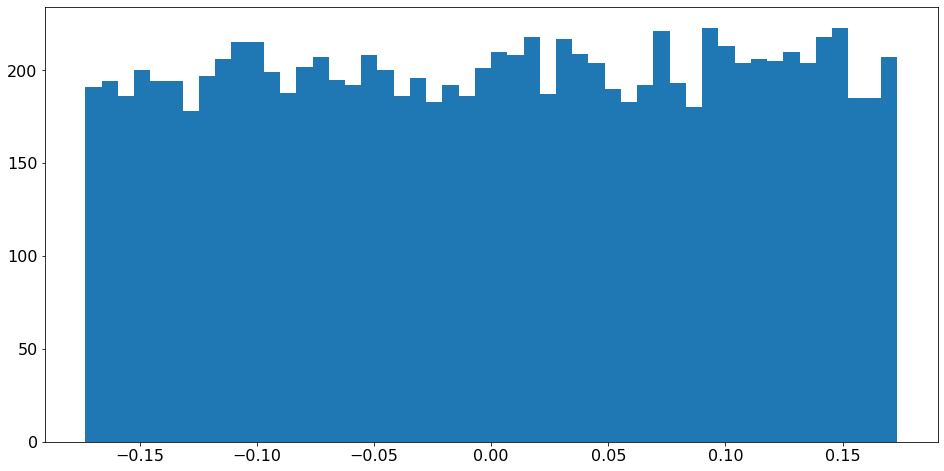

In [31]:
inits.glorot(vect2)
plt.hist(vect2.flatten().numpy(), bins=50);

### assegno a parameter un array precalcolato

In [ ]:
d.weight.data = torch.full((8, 8), 0.5)
#####
custom_weight = torch.rand(model.fc1.weight.shape)
model.fc1.weight = torch.nn.Parameter(custom_weight)

In [ ]:
# ??? forse no
for layer in model.state_dict():
    model.state_dict()[layer] = nn.parameter.Parameter(torch.ones_like(model.state_dict()[layer]))
for param in mask_model.parameters():
    param.data = nn.parameter.Parameter(torch.ones_like(param))

In [ ]:
def init_all(model, init_funcs):
    for p in model.parameters():
        init_func = init_funcs.get(len(p.shape), init_funcs["default"])
        init_func(p)

model = UNet(3, 10)
init_funcs = {
    1: lambda x: torch.nn.init.normal_(x, mean=0., std=1.), # can be bias
    2: lambda x: torch.nn.init.xavier_normal_(x, gain=1.), # can be weight
    3: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # can be conv1D filter
    4: lambda x: torch.nn.init.xavier_uniform_(x, gain=1.), # can be conv2D filter
    "default": lambda x: torch.nn.init.constant(x, 1.), # everything else
}

init_all(model, init_funcs)

In [ ]:
import torch.nn as nn        

# a simple network
rand_net = nn.Sequential(nn.Linear(in_features, h_size),
                         nn.BatchNorm1d(h_size),
                         nn.ReLU(),
                         nn.Linear(h_size, h_size),
                         nn.BatchNorm1d(h_size),
                         nn.ReLU(),
                         nn.Linear(h_size, 1),
                         nn.ReLU())

# initialization function, first checks the module type,
# then applies the desired changes to the weights
def init_normal(m):
    classname = m.__class__.__name__
    if type(m) == nn.Linear:
    #if classname.find('Linear') != -1:
        nn.init.uniform_(m.weight)
        #m.weight.data.uniform_(0.0, 1.0)
        #m.bias.data.fill_(0)
        
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

def weights_init_normal(m):
    '''Takes in a module and initializes all linear layers with weight
       values taken from a normal distribution.'''
    classname = m.__class__.__name__
    # for every Linear layer in a model
    if classname.find('Linear') != -1:
        y = m.in_features
    # m.weight.data shoud be taken from a normal distribution
        m.weight.data.normal_(0.0,1/np.sqrt(y))
    # m.bias.data should be 0
        m.bias.data.fill_(0)
            
        
# use the modules apply function to recursively apply the initialization
rand_net.apply(init_normal)



In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

net = nn.Sequential(nn.Linear(2, 2), nn.Linear(2, 2))
net.apply(init_weights)

In [ ]:
import torch.nn as nn


class Model(nn.Module):
    def __init__(self):
        self.apply(self._init_weights)
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=1.0)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight.data,nonlinearity='relu')


In [ ]:
def reset_parameters(self):
    stdv = 1. / math.sqrt(self.weight.size(1))
    self.weight.data.uniform_(-stdv, stdv)
    if self.bias is not None:
        self.bias.data.uniform_(-stdv, stdv)


##### from https://adityassrana.github.io/blog/theory/2020/08/26/Weight-Init.html#Okay,-now-why-can't-we-trust-PyTorch-to-initialize-our-weights-for-us-by-default?

In [ ]:
conv = nn.Conv2d(ni, nf, kernel_size=ks,stride=stride,padding=padding, **kwargs)
nn.init.kaiming_normal_(conv.weight)

In [ ]:
for m in self.modules():
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

In [ ]:
# Zero-initialize the last BN in each residual branch,
# so that the residual branch starts with zeros, and each residual block behaves like an identity.
# This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
if zero_init_residual:
    for m in self.modules():
        if isinstance(m, Bottleneck):
            nn.init.constant_(m.bn3.weight, 0)
        elif isinstance(m, BasicBlock):
            nn.init.constant_(m.bn2.weight, 0)